Before starting this notebook make sure that:
1. You have generated datasets for google-siglip2-base-patch16-512 model using the ../../dataset_generation/generation.sh script
2. You have trained your weights or taken already trained weights and placed them in the ../precalculated_weights folder

In [1]:
device = 'cuda:0'
vision_model_name = 'google/siglip2-base-patch16-512'
feature_extractor_weights_dir = '../../feature_extractor_weights'
reconstructor_weights_path = '../precalculated_weights/models--google--siglip2-base-patch16-512.pt'
json_path = f'../../generated_datasets/{"-".join(vision_model_name.split("/"))}/map_val.json'

## Let's verify that the files and directories exist:

The feature_extractor_weights_dir folder and the json_path file should appear after the dataset generation.

In [9]:
import os
print('dir with feature extractor weights: ', os.path.isdir(feature_extractor_weights_dir))
print('file with weights of reconstructor R: ', os.path.isfile(reconstructor_weights_path))
print('file with pathes to data: ', os.path.isfile(json_path))

dir with feature extractor weights:  True
file with weights of reconstructor R:  True
file with pathes to data:  True


## Downloading the feature extractor.

In [10]:
import torch
import numpy as np
from torch import nn
from torch.nn import functional as F
from transformers import SiglipVisionConfig, AutoImageProcessor, SiglipVisionModel

class SigLipVisionTower(nn.Module):
    def __init__(self, vision_model_name, weights_dir):
        super().__init__()

        self.is_loaded = False

        self.vision_tower_name = vision_model_name
        self.weights_dir = weights_dir
        self.processor_path = 'facebook/dinov2-base'
        self.select_layer = -2
        self.cfg_only = SiglipVisionConfig.from_pretrained(self.vision_tower_name, cache_dir=self.weights_dir)

    def load_model(self, device_map=None):
        if self.is_loaded:
            return

        self.image_processor = AutoImageProcessor.from_pretrained(self.processor_path, 
                                                                  cache_dir=self.weights_dir, 
                                                                  crop_size={"height": self.cfg_only.image_size, 
                                                                             "width": self.cfg_only.image_size},
                                                                  image_mean=[0.5, 0.5, 0.5], 
                                                                  image_std=[0.5, 0.5, 0.5], 
                                                                  size={"shortest_edge": self.cfg_only.image_size})
        self.vision_tower = SiglipVisionModel.from_pretrained(self.vision_tower_name, 
                                                              cache_dir=self.weights_dir, 
                                                              device_map=device_map)

        self.vision_tower.vision_model.head = nn.Identity()
        self.vision_tower.requires_grad_(False)
        self.eval()

        self.is_loaded = True

    def forward(self, images):
        if type(images) is list:
            image_features = []
            for image in images:
                image_forward_out = self.vision_tower(image.to(device=self.device, dtype=self.dtype).unsqueeze(0), output_hidden_states=True)
                image_feature = image_forward_out.hidden_states[self.select_layer].to(image.dtype)
                image_features.append(image_feature)
        return image_features

    @property
    def dtype(self):
        for p in self.vision_tower.parameters():
            return p.dtype

    @property
    def device(self):
        for p in self.vision_tower.parameters():
            return p.device

    @property
    def config(self):
        if self.is_loaded:
            return self.vision_tower.config
        else:
            return self.cfg_only

    @property
    def hidden_size(self):
        return self.config.hidden_size

    @property
    def num_patches(self):
        return (self.config.image_size // self.config.patch_size) ** 2

    @property
    def num_patches_per_side(self):
        return self.config.image_size // self.config.patch_size

    @property
    def image_size(self):
        return self.config.image_size
    
vision_tower = SigLipVisionTower(vision_model_name, feature_extractor_weights_dir)
vision_tower.load_model(device_map=device)

/home/jovyan/.mlspace/envs/visual-features-interpretation/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.50, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


### For each image, I create an analog of it by swapping the r and b channels in places.

On five pictures I will train and on another five I will check the result. Turns out five pictures are enough to learn a turn!

In [11]:
IMAGE_PREFIX = "../../"

In [12]:
import os
import json
import numpy as np
from PIL import Image
from tqdm import tqdm


def rgb_to_bgr(im):
    gbr_im = np.array(im)[:, :, ::-1]
    gbr_im = Image.fromarray(gbr_im).convert('RGB')
    return gbr_im


def load_and_process_images(json_path, processor, number):
    with open(json_path, 'r') as json_file:
        json_dict = json.load(json_file)

    ###################### images_list #########################
    images_pathes_list = []
    for i, (im_path, _) in enumerate(json_dict.items()):
        if i == number: break
        images_pathes_list.append(os.path.join(IMAGE_PREFIX, im_path))
    images_list = [Image.open(p).convert('RGB') for p in tqdm(images_pathes_list)]

    ###################### gbr_images_list #########################
    processed_images_list = []
    for im in tqdm(images_list):
        gbr_im = processor(im)
        processed_images_list.append(gbr_im)
    
    return images_list, processed_images_list

N_train, N_val = 5, 5
all_images_list, all_processed_images_list = load_and_process_images(json_path, rgb_to_bgr, number=N_train + N_val)

images_list, processed_images_list = all_images_list[-N_train:], all_processed_images_list[-N_train:]
val_images_list, val_processed_images_list = all_images_list[:N_val], all_processed_images_list[:N_val]

100%|██████████| 10/10 [00:00<00:00, 174.94it/s]


### Counting features for initial and modified images.

In [13]:
IMAGE_SIZE = 32

In [14]:
import numpy as np
from tqdm import tqdm
from torch.nn import functional as F


@torch.no_grad()
def calc_feature(me):
    inputs = vision_tower.image_processor(me, return_tensors="pt")['pixel_values'].to(device)[0]
    features = vision_tower([inputs])

    features = features[0].reshape(IMAGE_SIZE, IMAGE_SIZE, 768)
    features = features.permute(2, 0, 1)
    features = features / features.norm(dim=0, keepdim=True)
    return inputs, features


def calc_features_for_images_and_processed_images(images_list, processed_images_list):
    inputs_list = []
    feature_list = []
    for im in tqdm(images_list):
        inputs, features = calc_feature(im)
        inputs_list.append(inputs.cpu())
        feature_list.append(features.cpu())

    processed_inputs_list = []
    processed_feature_list = []
    for im in tqdm(processed_images_list):
        inputs, features = calc_feature(im)
        processed_inputs_list.append(inputs.cpu())
        processed_feature_list.append(features.cpu())
    
    return inputs_list, feature_list, processed_inputs_list, processed_feature_list

inputs_list, feature_list, processed_inputs_list, processed_feature_list = calc_features_for_images_and_processed_images(images_list, processed_images_list)

100%|██████████| 5/5 [00:00<00:00, 31.82it/s]


In [15]:
features = torch.stack(feature_list).to(device)
processed_feature = torch.stack(processed_feature_list).to(device)

### Compute the orthogonal matrix on the training sample:

In [20]:
features.shape

torch.Size([5, 768, 32, 32])

In [51]:

real_F = features.permute(2, 3, 0, 1).flatten(0, 2)
gbr_F = processed_feature.permute(2, 3, 0, 1).flatten(0, 2)

print("real_F, gbr_F", real_F.shape, gbr_F.shape)
M = real_F.permute(1, 0) @ gbr_F
# return M
print("M", M.shape)
U, S, Vh = torch.linalg.svd(M)
Q = U @ Vh
print("Q", Q.shape)


real_F, gbr_F torch.Size([5120, 768]) torch.Size([5120, 768])
M torch.Size([768, 768])
Q torch.Size([768, 768])


In [61]:
S.min()

tensor(0.0042, device='cuda:0')

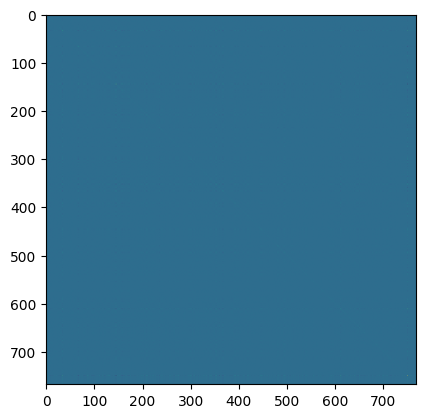

In [53]:
plt.imshow(M.cpu().numpy())

In [34]:
def calculate_Q(real_F, gbr_F): # [1024, 1024]
    print("real_F, gbr_F", real_F.shape, gbr_F.shape)
    M = real_F.permute(1, 0) @ gbr_F
    # return M
    print("M", M.shape)
    U, S, Vh = torch.linalg.svd(M)
    Q = U @ Vh
    print("Q", Q.shape)
    return Q

Q = calculate_Q(features.permute(2, 3, 0, 1).flatten(0, 2),
                processed_feature.permute(2, 3, 0, 1).flatten(0, 2))

real_F, gbr_F torch.Size([5120, 768]) torch.Size([5120, 768])
M torch.Size([768, 768])
Q torch.Size([768, 768])


In [68]:
# import pandas as pd
sorted(Q.diag().cpu().numpy())

[np.float32(0.18975517),
 np.float32(0.76790476),
 np.float32(0.7776376),
 np.float32(0.78133726),
 np.float32(0.8076707),
 np.float32(0.83258426),
 np.float32(0.8369087),
 np.float32(0.8371272),
 np.float32(0.8375664),
 np.float32(0.8380885),
 np.float32(0.83870894),
 np.float32(0.8395978),
 np.float32(0.84150356),
 np.float32(0.8425366),
 np.float32(0.84448504),
 np.float32(0.8462365),
 np.float32(0.85003614),
 np.float32(0.85190636),
 np.float32(0.8534231),
 np.float32(0.853745),
 np.float32(0.85379785),
 np.float32(0.8542971),
 np.float32(0.85484123),
 np.float32(0.8549105),
 np.float32(0.85525525),
 np.float32(0.8552914),
 np.float32(0.855371),
 np.float32(0.85623425),
 np.float32(0.8568324),
 np.float32(0.8569413),
 np.float32(0.85703766),
 np.float32(0.85726565),
 np.float32(0.8580476),
 np.float32(0.8582134),
 np.float32(0.85862565),
 np.float32(0.85867006),
 np.float32(0.85902834),
 np.float32(0.8598591),
 np.float32(0.86041516),
 np.float32(0.86047685),
 np.float32(0.86059034

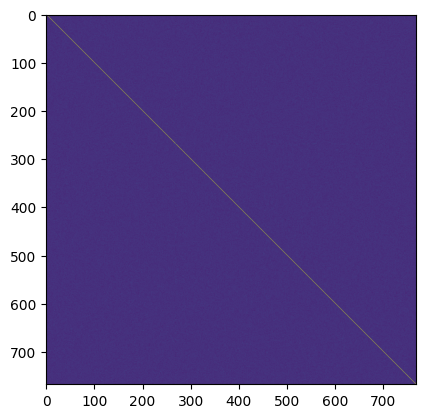

In [37]:
import matplotlib.pyplot as plt

plt.imshow( Q.cpu().numpy() )

### Apply the transformation and restore the changed fiches on the validation sample.

In [46]:
def apply_Q(Fe, Q, n=1):
    gbr_Fe = torch.zeros_like(Fe)

    Qn = Q
    for _ in range(n - 1):
        Qn = Qn @ Q

    for i in range(Fe.shape[1]):
        for j in range(Fe.shape[2]):
            gbr_Fe[:, i, j] = Fe[:, i, j] @ Qn
    return gbr_Fe


@torch.no_grad()
def interpolate(im, Fe, model, device):
    processed_image = torch.tensor(im).to(device)
    processed_Fe = Fe.to(device)
    reconstructed_image, processed_Fe, check_dict = model.forward(processed_Fe, processed_image)
    return processed_image, reconstructed_image, processed_Fe, check_dict

image_mean = np.array(vision_tower.image_processor.image_mean)
image_std = np.array(vision_tower.image_processor.image_std)
def from_1_to_255(image, image_mean, image_std):
    image_unnormed = np.asarray(image) * image_std[:, None, None] + image_mean[:, None, None]
    image_01 = image_unnormed.clip(0, 1)
    image_255 = image_01 * 255
    image_255_uint = np.array(image_255, dtype=np.uint8)
    return image_255_uint

In [47]:
from model import R
model = R(vision_model_name, feature_extractor_weights_dir).to(device)
model.load_state_dict(torch.load(reconstructor_weights_path, weights_only=True), strict=True)
model.eval();

In [48]:
import torch.nn.functional as F
from PIL import Image

def Qed(images_list, Q, n=1):
    inputs_list, features_list, Qed_features_list, processed_inputs_list, processed_features_list = [], [], [], [], []

    for im in tqdm(images_list):
        inputs, features = calc_feature(im)
        processed_inputs, processed_features = calc_feature(rgb_to_bgr(im))
        Qed_me_features = apply_Q(features, Q, n)
        
        inputs_list.append(inputs)
        features_list.append(features)
        processed_inputs_list.append(processed_inputs)
        processed_features_list.append(processed_features)
        Qed_features_list.append(Qed_me_features)

    return inputs_list, features_list, Qed_features_list, processed_inputs_list, processed_features_list

inputs_list, features_list, Qed_features_list, processed_inputs_list, processed_features_list = Qed(val_images_list[:10], Q)

100%|██████████| 5/5 [00:00<00:00,  9.61it/s]


In [49]:
def interpolate_all_features(inputs_list, features_list, Qed_features_list, 
                             processed_inputs_list, processed_features_list, 
                             get_features_of_recs=False, get_features_of_processed_recs=False):
    inter_list, rec_list, processed_inter_list, processed_rec_list, Qed_rec_list = [], [], [], [], []
    if get_features_of_recs: features_of_recs_list = []
    if get_features_of_processed_recs: features_of_processed_recs_list = []
    
    z = zip(tqdm(inputs_list), features_list, Qed_features_list, processed_inputs_list, processed_features_list)
    for inputs, features, Qed_features, processed_inputs, processed_features in z:
        inter, rec, _, _ = interpolate(inputs[None], features[None], model, device)
        _, Qed_rec, _, _ = interpolate(inputs[None], Qed_features[None], model, device)
        processed_inter, processed_rec, _, _ = interpolate(processed_inputs[None], processed_features[None], model, device)

        inter = from_1_to_255(inter[0].cpu(), image_mean, image_std)
        rec = from_1_to_255(rec[0].cpu(), image_mean, image_std)
        processed_inter = from_1_to_255(processed_inter[0].cpu(), image_mean, image_std)
        processed_rec = from_1_to_255(processed_rec[0].cpu(), image_mean, image_std)
        Qed_rec = from_1_to_255(Qed_rec[0].cpu(), image_mean, image_std)

        inter_list.append(inter)
        rec_list.append(rec)
        processed_inter_list.append(processed_inter)
        processed_rec_list.append(processed_rec)
        Qed_rec_list.append(Qed_rec)

        if get_features_of_recs:
            feature_of_rec = calc_feature(Image.fromarray(Qed_rec.transpose(1, 2, 0)))
            features_of_recs_list.append(feature_of_rec[-1].cpu())
        if get_features_of_processed_recs:
            features_of_processed_recs = calc_feature(Image.fromarray(processed_rec.transpose(1, 2, 0)))
            features_of_processed_recs_list.append(features_of_processed_recs[-1].cpu())
    
    if get_features_of_recs and (not get_features_of_processed_recs):
        return inter_list, rec_list, processed_inter_list, processed_rec_list, Qed_rec_list, features_of_recs_list
    if (not get_features_of_recs) and get_features_of_processed_recs:
        return inter_list, rec_list, processed_inter_list, processed_rec_list, Qed_rec_list, features_of_processed_recs_list
    if get_features_of_recs and get_features_of_processed_recs:
        return inter_list, rec_list, processed_inter_list, processed_rec_list, Qed_rec_list, features_of_recs_list, features_of_processed_recs_list
    
    return inter_list, rec_list, processed_inter_list, processed_rec_list, Qed_rec_list

inter_list, rec_list, processed_inter_list, processed_rec_list, Qed_rec_list, features_of_recs_list, features_of_processed_recs_list = \
interpolate_all_features(inputs_list, features_list, Qed_features_list, 
                         processed_inputs_list, processed_features_list, 
                         get_features_of_recs=True, get_features_of_processed_recs=True)

  0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipykernel_428561/3103030834.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  processed_image = torch.tensor(im).to(device)
100%|██████████| 5/5 [00:00<00:00,  8.38it/s]


### Draw the result.

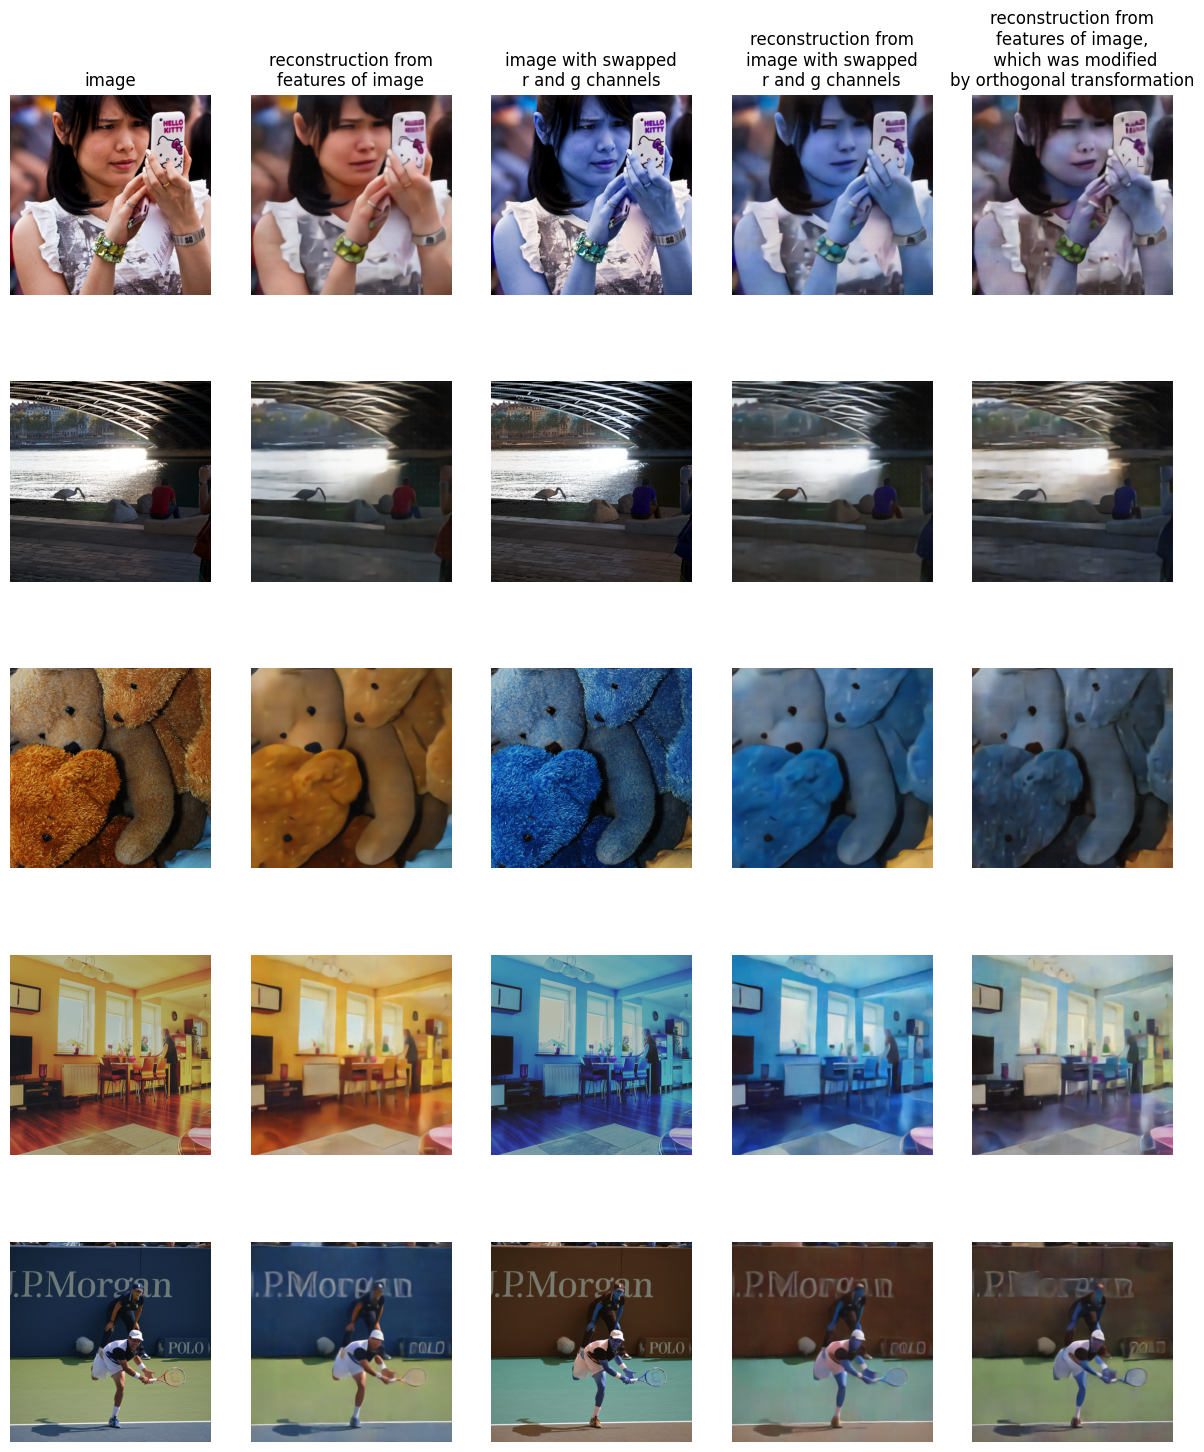

In [50]:
import matplotlib.pyplot as plt
def draw(inter_list, rec_list, 
         processed_inter_list, processed_rec_list, 
         Qed_rec_list, 
         Qed_features_list=None, processed_features_list=None, features_of_recs_list=None, features_of_processed_recs_list=None):
    ncols, nrows, scale = 5, len(inter_list), 3
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols * scale, (nrows + 1) * scale))

    for i in range(nrows):
        axes[i, 0].imshow(inter_list[i].transpose(1, 2, 0))
        axes[i, 1].imshow(rec_list[i].transpose(1, 2, 0))
        axes[i, 2].imshow(processed_inter_list[i].transpose(1, 2, 0))
        axes[i, 3].imshow(processed_rec_list[i].transpose(1, 2, 0))
        axes[i, 4].imshow(Qed_rec_list[i].transpose(1, 2, 0))

        axes[i, 0].axis('off')
        axes[i, 1].axis('off')
        axes[i, 2].axis('off')
        axes[i, 3].axis('off')
        axes[i, 4].axis('off')

        title_4 = ''
        if i == 0:
            axes[i, 0].set_title('image')
            axes[i, 1].set_title('reconstruction from\n'
                                 'features of image')
            axes[i, 2].set_title('image with swapped\n'
                                 'r and g channels')
            axes[i, 3].set_title('reconstruction from\n'
                                 'image with swapped\n'
                                 'r and g channels')
            axes[i, 4].set_title('reconstruction from\n'+\
                                 'features of image,\n'+\
                                 ' which was modified\n'+\
                                 'by orthogonal transformation')
        
        if (Qed_features_list is not None) and (processed_features_list is not None):
            x1 = Qed_features_list[i].cpu()
            x2 = processed_features_list[i].cpu()
            mean_cos = round((x1 * x2).sum(dim=0).mean().item(), 2)

        if (Qed_features_list is not None) and (features_of_recs_list is not None):
            x1 = Qed_features_list[i].cpu()
            x2 = features_of_recs_list[i].cpu()
            mean_cos = round((x1 * x2).sum(dim=0).mean().item(), 2)

        if (Qed_features_list is not None) and (features_of_processed_recs_list is not None):
            x1 = Qed_features_list[i].cpu()
            x2 = features_of_processed_recs_list[i].cpu()
            mean_cos = round((x1 * x2).sum(dim=0).mean().item(), 2)

    plt.show()

draw(inter_list, rec_list, 
     processed_inter_list, processed_rec_list, 
     Qed_rec_list, 
     Qed_features_list, processed_features_list, features_of_recs_list, features_of_processed_recs_list)


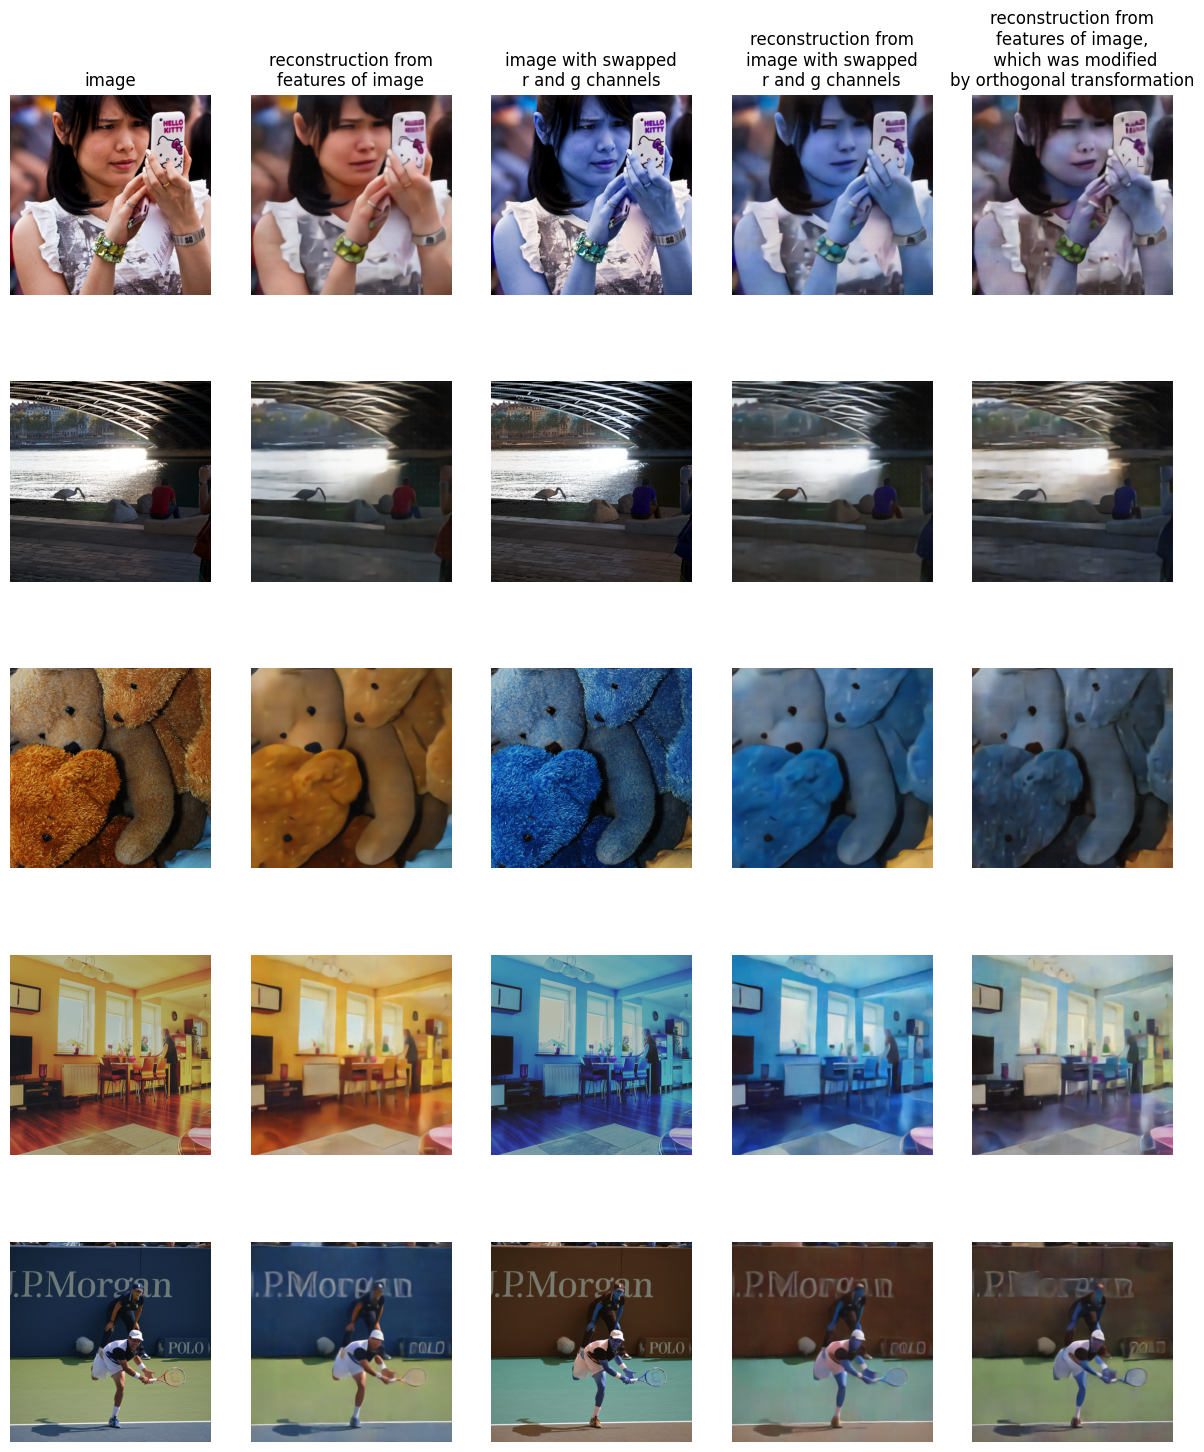